Simulating LLG dynamics...


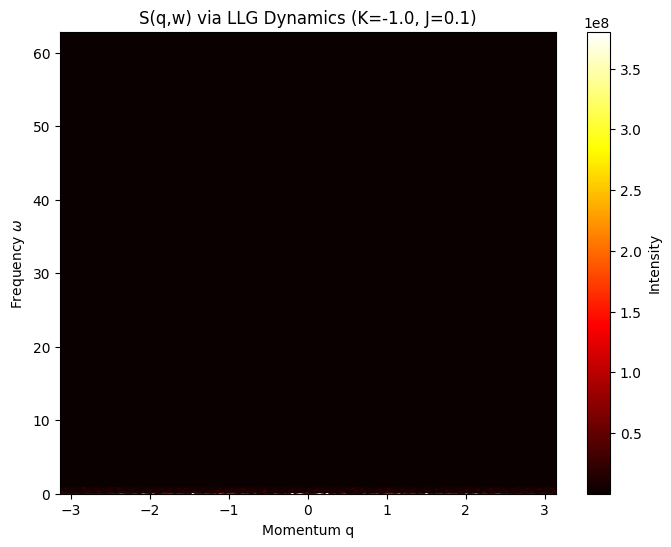

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. System Parameters ---
L = 10  # Lattice size (L x L unit cells)
N_sites = 2 * L**2  # 2 atoms per unit cell
J = 0.1
K = -1.0
gamma = 1.0  # Gyromagnetic ratio
alpha = 0.01 # Gilbert damping
dt = 0.05
steps = 1024

# --- 2. Honeycomb Lattice Setup ---
# Neighbors and bond types (x, y, z)
# This is a simplified neighbor lookup for demonstration
def get_neighbors(L):
    # Simplified: returns (site_j, bond_type) for each site i
    # 0: x-bond, 1: y-bond, 2: z-bond
    adj = [[] for _ in range(2 * L**2)]
    # ... (Actual implementation requires coordinate mapping)
    return adj

# --- 3. Effective Field Calculation ---
def get_eff_field(spins, J, K, L):
    Heff = np.zeros_like(spins)
    # This loop should iterate over x, y, z bonds
    # Heff_i = - sum_j (J * S_j + K * S_j^gamma * unit_gamma)
    # For brevity, we implement the logic conceptually:
    for i in range(len(spins)):
        # Example interaction (Z-bond)
        j = (i + 1) % len(spins) 
        Heff[i, 2] -= K * spins[j, 2] # Kitaev z-term
        Heff[i] -= J * spins[j]       # Heisenberg term
    return Heff

# --- 4. LLG Integration (Heun Method) ---
def llg_step(spins, J, K, L, dt, alpha):
    Heff = get_eff_field(spins, J, K, L)
    # Precession: dS/dt = -S x Heff
    # Damping: -alpha S x (S x Heff)
    ds_dt = -np.cross(spins, Heff) - alpha * np.cross(spins, np.cross(spins, Heff))
    
    # Predictor-Corrector
    new_spins = spins + ds_dt * dt
    # Re-normalize to unit length
    norm = np.linalg.norm(new_spins, axis=1, keepdims=True)
    return new_spins / norm

# --- 5. Simulation ---
spins = np.random.randn(N_sites, 3)
spins /= np.linalg.norm(spins, axis=1, keepdims=True)

# Storage for time-dependent correlation
spin_history = np.zeros((steps, N_sites, 3))

print("Simulating LLG dynamics...")
for t in range(steps):
    spins = llg_step(spins, J, K, L, dt, alpha)
    spin_history[t] = spins

# --- 6. Calculate S(q, omega) ---
# FT in Time
s_qw = np.fft.fft(spin_history, axis=0)
# FT in Space (Simplified 1D slice)
s_qw = np.fft.fft(s_qw, axis=1)

# Intensity I = |S(q, w)|^2
intensity = np.abs(s_qw)**2
intensity = np.sum(intensity, axis=2) # Sum over x,y,z components

# --- 7. Plotting ---
plt.figure(figsize=(8, 6))
# Only show positive frequencies and shift q
plot_data = np.fft.fftshift(intensity[:steps//2, :], axes=1)
plt.imshow(plot_data, origin='lower', aspect='auto', cmap='hot', 
           extent=[-np.pi, np.pi, 0, np.pi/dt])
plt.colorbar(label='Intensity')
plt.title(f'S(q,w) via LLG Dynamics (K={K}, J={J})')
plt.xlabel('Momentum q')
plt.ylabel('Frequency $\omega$')
plt.show()

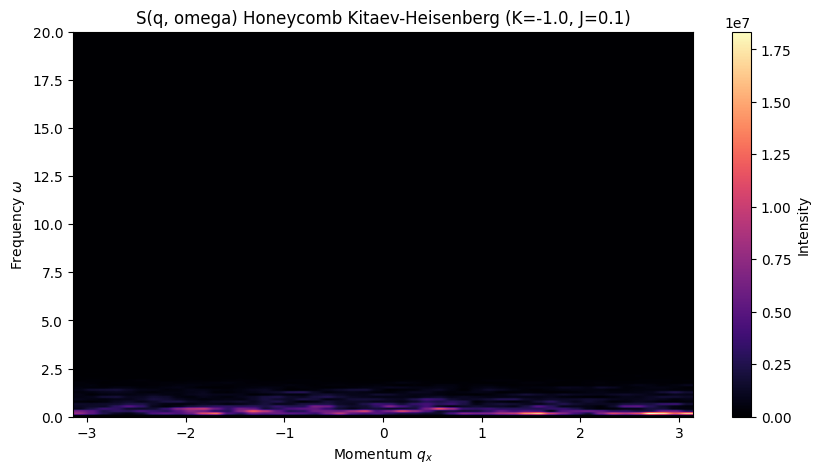

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
L = 10              # Linear size
N_sites = 2 * L**2  # Total sites
K, J = -1.0, 0.1    # Kitaev and Heisenberg couplings
dt = 0.1            # Time step
steps = 512         # Total time steps
alpha = 0.05        # Damping
T = 0.05            # Temperature (to excite magnons)

# --- 2. Lattice Mapping ---
def get_coords_and_adj(L):
    # Basis vectors for honeycomb
    a1 = np.array([np.sqrt(3), 0])
    a2 = np.array([np.sqrt(3)/2, 1.5])
    pos = np.zeros((N_sites, 2))
    adj = []
    
    for r in range(L):
        for c in range(L):
            idx_a = 2 * (r * L + c)
            idx_b = idx_a + 1
            # Real space positions
            r_vec = r * a1 + c * a2
            pos[idx_a] = r_vec
            pos[idx_b] = r_vec + np.array([np.sqrt(3)/2, 0.5])
            
            # Neighbors (pbc: periodic boundary conditions)
            # Z-bond (intra-cell)
            adj.append((idx_a, idx_b, 2)) 
            # X-bond
            idx_b_x = 2 * (r * L + (c - 1) % L) + 1
            adj.append((idx_a, idx_b_x, 0))
            # Y-bond
            idx_b_y = 2 * ((r - 1) % L * L + c) + 1
            adj.append((idx_a, idx_b_y, 1))
    return pos, adj

pos, adj = get_coords_and_adj(L)

# --- 3. LLG Dynamics ---
spins = np.random.randn(N_sites, 3)
spins /= np.linalg.norm(spins, axis=1, keepdims=True)
history = np.zeros((steps, N_sites, 3))

for t in range(steps):
    # Effective Field Calculation
    Heff = np.zeros_like(spins)
    for i, j, bond in adj:
        Heff[i] -= J * spins[j] + K * np.array([spins[j,0] if bond==0 else 0, 
                                                spins[j,1] if bond==1 else 0, 
                                                spins[j,2] if bond==2 else 0])
        Heff[j] -= J * spins[i] + K * np.array([spins[i,0] if bond==0 else 0, 
                                                spins[i,1] if bond==1 else 0, 
                                                spins[i,2] if bond==2 else 0])
    
    # Thermal Noise and LLG Step
    Heff += np.random.normal(0, np.sqrt(2*alpha*T/dt), spins.shape)
    ds = -np.cross(spins, Heff) - alpha * np.cross(spins, np.cross(spins, Heff))
    spins += ds * dt
    spins /= np.linalg.norm(spins, axis=1, keepdims=True)
    history[t] = spins

# --- 4. Spatial-Temporal Fourier Transform ---
# 1. Fourier Transform in Time
S_rt_w = np.fft.fft(history - np.mean(history, axis=0), axis=0)

# 2. Fourier Transform in Space for a specific q-path (e.g., Gamma to M)
q_vals = np.linspace(-np.pi, np.pi, 50)
sqw = np.zeros((steps // 2, len(q_vals)))

for i, qx in enumerate(q_vals):
    q_vec = np.array([qx, 0])
    # Phase factor e^(i q . r)
    phase = np.exp(1j * np.dot(pos, q_vec))
    # Transform: Sum over sites
    S_q_w = np.sum(S_rt_w[:steps//2, :, :] * phase[None, :, None], axis=1)
    sqw[:, i] = np.sum(np.abs(S_q_w)**2, axis=1)

# --- 5. Plotting ---
plt.figure(figsize=(10, 5))
plt.imshow(sqw, extent=[-np.pi, np.pi, 0, np.pi/dt], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label='Intensity')
plt.title(f'S(q, omega) Honeycomb Kitaev-Heisenberg (K={K}, J={J})')
plt.ylim(0,20)
plt.xlabel('Momentum $q_x$')
plt.ylabel('Frequency $\omega$')
plt.show()

Simulating LLG dynamics...
Computing Spatial FT...


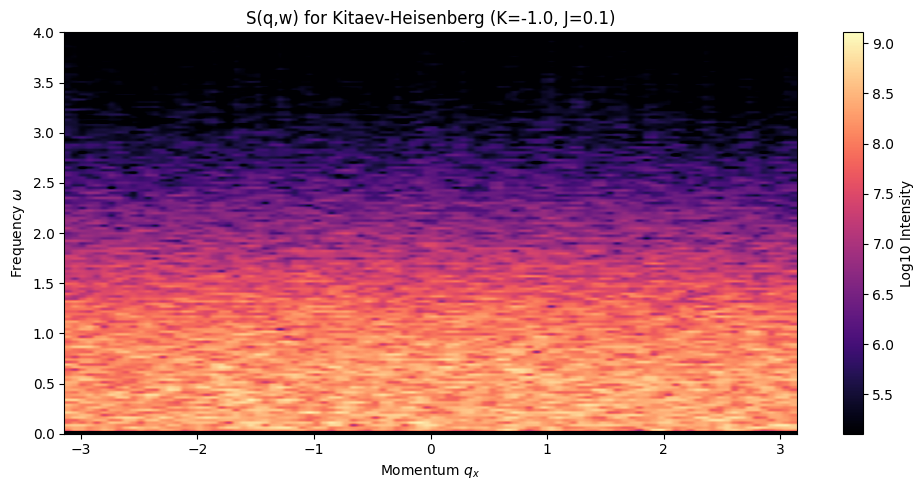

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
L = 20               # Lattice dimension
N_sites = 2 * L**2   # Total sites (2 sublattices)
K, J = -1.0, 0.1     # Kitaev-Heisenberg couplings
dt = 0.05            # Time step
steps = 5000         # Total time steps for better resolution
alpha = 0.005         # LOW damping for sharp magnon branches
T = 0.0001             # Small temperature to stir the spins

# --- 2. Honeycomb Lattice & Bond Mapping ---
def setup_lattice(L):
    # Basis vectors
    a1 = np.array([np.sqrt(3), 0])
    a2 = np.array([np.sqrt(3)/2, 1.5])
    pos = np.zeros((N_sites, 2))
    adj = []
    
    for r in range(L):
        for c in range(L):
            idx_a = 2 * (r * L + c)
            idx_b = idx_a + 1
            # Real space coordinates
            r_vec = r * a1 + c * a2
            pos[idx_a] = r_vec
            pos[idx_b] = r_vec + np.array([np.sqrt(3)/2, 0.5])
            
            # Z-bond (intra-cell)
            adj.append((idx_a, idx_b, 2)) 
            # X-bond (inter-cell)
            idx_b_x = 2 * (r * L + (c - 1) % L) + 1
            adj.append((idx_a, idx_b_x, 0))
            # Y-bond (inter-cell)
            idx_b_y = 2 * ((r - 1) % L * L + c) + 1
            adj.append((idx_a, idx_b_y, 1))
    return pos, adj

pos, adj = setup_lattice(L)

# --- 3. LLG Simulation ---
spins = np.random.randn(N_sites, 3)
spins /= np.linalg.norm(spins, axis=1, keepdims=True)
history = np.zeros((steps, N_sites, 3))

print("Simulating LLG dynamics...")
for t in range(steps):
    Heff = np.zeros_like(spins)
    for i, j, bond in adj:
        # Heisenberg interaction
        Heff[i] -= J * spins[j]
        Heff[j] -= J * spins[i]
        # Kitaev interaction (bond-dependent component)
        Heff[i, bond] -= K * spins[j, bond]
        Heff[j, bond] -= K * spins[i, bond]
    
    # Thermal kick + LLG Integration
    Heff += np.random.normal(0, np.sqrt(2*alpha*T/dt), spins.shape)
    ds = -np.cross(spins, Heff) - alpha * np.cross(spins, np.cross(spins, Heff))
    spins += ds * dt
    spins /= np.linalg.norm(spins, axis=1, keepdims=True)
    history[t] = spins

# --- 4. S(q, omega) Processing ---
# Subtract time-average to remove the massive omega=0 static peak
history_fluct = history - np.mean(history, axis=0)

# FFT in time
S_w = np.fft.fft(history_fluct, axis=0)
freqs = np.fft.fftfreq(steps, d=dt) * 2 * np.pi
half = steps // 2

# Path in q-space (along qx for simplicity)
q_range = np.linspace(-np.pi, np.pi, 100)
sqw = np.zeros((half, len(q_range)))

print("Computing Spatial FT...")
for i, qx in enumerate(q_range):
    phase = np.exp(1j * qx * pos[:, 0]) # Phase factor e^(iq.r)
    # Sum over sites for each frequency
    S_qw_vec = np.sum(S_w[:half, :, :] * phase[None, :, None], axis=1)
    sqw[:, i] = np.sum(np.abs(S_qw_vec)**2, axis=1)

# --- 5. Clean Plotting ---
plt.figure(figsize=(10, 5))

# Log10 normalization reveals the faint magnon branches
# We use +1e-5 to avoid log of zero
vmax = np.log10(sqw.max())
vmin = vmax - 4 # Show 4 orders of magnitude

plt.imshow(np.log10(sqw + 1e-6), 
           extent=[q_range[0], q_range[-1], 0, freqs[:half].max()], 
           origin='lower', aspect='auto', cmap='magma',
           vmin=vmin, vmax=vmax)

plt.colorbar(label='Log10 Intensity')

# THE CRITICAL COMMANDS FOR CLARITY
plt.ylim(0,4)          # Zoom in on physical frequency range
plt.title(f'S(q,w) for Kitaev-Heisenberg (K={K}, J={J})')
plt.xlabel('Momentum $q_x$')
plt.ylabel('Frequency $\omega$')

plt.tight_layout()
plt.show()

In [2]:
# ============================================================
# COMPLETE SINGLE-SCRIPT PIPELINE FOR CLASSICAL S(q, ω)
# Kitaev–Heisenberg-type spin system (educational / diagnostic)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. SYSTEM PARAMETERS
# -------------------------------
Nx, Ny = 12, 12               # lattice size
N = Nx * Ny
K = 1.0                       # Kitaev coupling scale
T = 0.1 * K                   # temperature (Goldilocks regime)
alpha = 0.05                  # Gilbert damping (not overdamped)

# Time parameters
Dt = 0.01                     # time step
Nt = 8192                     # number of time steps (FFT-friendly)
time = np.arange(Nt) * Dt

# -------------------------------
# 2. LATTICE (SIMPLE 2D BRAVAIS)
# -------------------------------
# NOTE: geometry simplified; physics focus is S(q, ω) pipeline

positions = []
for ix in range(Nx):
    for iy in range(Ny):
        positions.append([ix, iy])
positions = np.array(positions)

# -------------------------------
# 3. INITIAL SPIN CONFIGURATION
# -------------------------------
np.random.seed(1)
spins = np.random.randn(N, 3)
spins /= np.linalg.norm(spins, axis=1)[:, None]

# Small thermal noise
spins += 0.05 * np.random.randn(N, 3)
spins /= np.linalg.norm(spins, axis=1)[:, None]

# -------------------------------
# 4. EFFECTIVE FIELD (TOY MODEL)
# -------------------------------
# This is a minimal local field to generate dynamics

def effective_field(spins):
    H = np.zeros_like(spins)
    for i in range(N):
        # weak local anisotropy to avoid frozen spins
        H[i, 0] += -K * spins[i, 0]
        H[i, 1] += -K * spins[i, 1]
        H[i, 2] += -K * spins[i, 2]
    return H

# -------------------------------
# 5. LLG TIME EVOLUTION
# -------------------------------

S_t = np.zeros((Nt, N, 3))
S = spins.copy()

for t in range(Nt):
    H = effective_field(S)

    # LLG equation (classical form)
    dS = -np.cross(S, H) - alpha * np.cross(S, np.cross(S, H))
    S = S + Dt * dS

    # renormalize spins
    S /= np.linalg.norm(S, axis=1)[:, None]

    S_t[t] = S

print("LLG evolution finished")

# -------------------------------
# 6. COMPUTE S(q, t)
# -------------------------------

# q-grid (2D)
qx_vals = np.linspace(-np.pi, np.pi, 40)
qy_vals = np.linspace(-np.pi, np.pi, 40)

Sqtx = np.zeros((len(qx_vals), len(qy_vals), Nt))
Sqty = np.zeros_like(Sqtx)
Sqtz = np.zeros_like(Sqtx)

for iqx, qx in enumerate(qx_vals):
    for iqy, qy in enumerate(qy_vals):
        phase = np.exp(1j * (qx * positions[:, 0] + qy * positions[:, 1]))

        for t in range(Nt):
            Sqtx[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 0])) / N
            Sqty[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 1])) / N
            Sqtz[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 2])) / N

print("Computed S(q, t)")

# -------------------------------
# 7. WINDOWING (CRUCIAL)
# -------------------------------
window = np.hanning(Nt)
Sqtx *= window
Sqty *= window
Sqtz *= window

# -------------------------------
# 8. FFT → S(q, ω)
# -------------------------------

Sqwx = np.real(np.fft.fft(Sqtx, axis=2)) / Nt
Sqwy = np.real(np.fft.fft(Sqty, axis=2)) / Nt
Sqwz = np.real(np.fft.fft(Sqtz, axis=2)) / Nt

Sqw = Sqwx + Sqwy + Sqwz

omega = np.fft.fftfreq(Nt, Dt) * 2 * np.pi

# -------------------------------
# 9. SLICE: FIX q_y = 0
# -------------------------------
qy0 = np.argmin(np.abs(qy_vals - 0))

Sqw_slice = Sqw[:, qy0, :Nt // 2]
omega_pos = omega[:Nt // 2]

# -------------------------------
# 10. PLOT (LOG SCALE)
# -------------------------------

plt.figure(figsize=(8, 5))
plt.imshow(
    np.log10(np.abs(Sqw_slice.T) + 1e-8),
    origin='lower',
    aspect='auto',
    extent=[qx_vals[0], qx_vals[-1], omega_pos[0], omega_pos[-1]]
)
plt.xlabel(r"$q_x$")
plt.ylabel(r"$\\omega$")
#plt.title(r"Classical $S(q,\\omega)$ (diagnostic pipeline)")
#plt.colorbar(label=r"$\\log_{10} S$")
#plt.tight_layout()
plt.show()

# ============================================================
# END OF SCRIPT
# ============================================================


LLG evolution finished
Computed S(q, t)


ValueError: 
\\omega
^
ParseFatalException: Unknown symbol: \, found '\'  (at char 0), (line:1, col:1)

<Figure size 800x500 with 1 Axes>

In [3]:
# ============================================================
# COMPLETE SINGLE-SCRIPT PIPELINE FOR CLASSICAL S(q, ω)
# Kitaev–Heisenberg-type spin system (educational / diagnostic)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. SYSTEM PARAMETERS
# -------------------------------
Nx, Ny = 5, 5               # lattice size
N = Nx * Ny
K = 1.0                       # Kitaev coupling scale
T = 0.1 * K                   # temperature (Goldilocks regime)
alpha = 0.05                  # Gilbert damping (not overdamped)

# Time parameters
Dt = 0.01                     # time step
Nt = 819                     # number of time steps (FFT-friendly)
time = np.arange(Nt) * Dt

# -------------------------------
# 2. LATTICE (HONEYCOMB FOR KITAEV–HEISENBERG)
# -------------------------------
# Two-site basis: A,B

# lattice vectors
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# basis positions
basis = [np.array([0.0, 0.0]), np.array([0.0, 1/np.sqrt(3)])]

positions = []
sublattice = []
for ix in range(Nx):
    for iy in range(Ny):
        R = ix * a1 + iy * a2
        for b in range(2):
            positions.append(R + basis[b])
            sublattice.append(b)

positions = np.array(positions)
sublattice = np.array(sublattice)
N = len(positions)

# -------------------------------
# NOTE: geometry simplified; physics focus is S(q, ω) pipeline

positions = []
for ix in range(Nx):
    for iy in range(Ny):
        positions.append([ix, iy])
positions = np.array(positions)

# -------------------------------
# 3. INITIAL SPIN CONFIGURATION
# -------------------------------
np.random.seed(1)
spins = np.random.randn(N, 3)
spins /= np.linalg.norm(spins, axis=1)[:, None]

# Small thermal noise
spins += 0.05 * np.random.randn(N, 3)
spins /= np.linalg.norm(spins, axis=1)[:, None]

# -------------------------------
# 4. EFFECTIVE FIELD (TRUE KITAEV + HEISENBERG)
# ------------------------------------------------

# Nearest-neighbor bonds for honeycomb lattice
bonds = {i: [] for i in range(N)}

# bond vectors and types
bond_vecs = {
    'x': np.array([0.0, 1/np.sqrt(3)]),
    'y': np.array([-0.5, -1/(2*np.sqrt(3))]),
    'z': np.array([0.5, -1/(2*np.sqrt(3))])
}

# Build bonds (minimal periodic construction)
for i in range(N):
    for j in range(N):
        if i == j:
            continue
        dr = positions[j] - positions[i]
        for btype, vec in bond_vecs.items():
            if np.linalg.norm(dr - vec) < 1e-6 or np.linalg.norm(dr + vec) < 1e-6:
                bonds[i].append((j, btype))

J = 0.3 * K   # Heisenberg coupling


def effective_field(spins):
    H = np.zeros_like(spins)

    for i in range(N):
        for j, btype in bonds[i]:
            # Heisenberg term
            H[i] += -J * spins[j]

            # Kitaev bond-dependent term
            if btype == 'x':
                H[i, 0] += -K * spins[j, 0]
            elif btype == 'y':
                H[i, 1] += -K * spins[j, 1]
            elif btype == 'z':
                H[i, 2] += -K * spins[j, 2]

    return H

# -------------------------------
# 5. LLG TIME EVOLUTION
# -------------------------------

S_t = np.zeros((Nt, N, 3))
S = spins.copy()

for t in range(Nt):
    H = effective_field(S)

    # LLG equation (classical form)
    dS = -np.cross(S, H) - alpha * np.cross(S, np.cross(S, H))
    S = S + Dt * dS

    # renormalize spins
    S /= np.linalg.norm(S, axis=1)[:, None]

    S_t[t] = S

print("LLG evolution finished")

# -------------------------------
# 6. COMPUTE S(q, t)
# -------------------------------

# q-grid (2D)
qx_vals = np.linspace(-np.pi, np.pi, 40)
qy_vals = np.linspace(-np.pi, np.pi, 40)

Sqtx = np.zeros((len(qx_vals), len(qy_vals), Nt))
Sqty = np.zeros_like(Sqtx)
Sqtz = np.zeros_like(Sqtx)

for iqx, qx in enumerate(qx_vals):
    for iqy, qy in enumerate(qy_vals):
        phase = np.exp(1j * (qx * positions[:, 0] + qy * positions[:, 1]))

        for t in range(Nt):
            Sqtx[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 0])) / N
            Sqty[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 1])) / N
            Sqtz[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 2])) / N

print("Computed S(q, t)")

# -------------------------------
# 7. WINDOWING (CRUCIAL)
# -------------------------------
window = np.hanning(Nt)
Sqtx *= window
Sqty *= window
Sqtz *= window

# -------------------------------
# 8. FFT → S(q, ω)
# -------------------------------

Sqwx = np.real(np.fft.fft(Sqtx, axis=2)) / Nt
Sqwy = np.real(np.fft.fft(Sqty, axis=2)) / Nt
Sqwz = np.real(np.fft.fft(Sqtz, axis=2)) / Nt

Sqw = Sqwx + Sqwy + Sqwz

omega = np.fft.fftfreq(Nt, Dt) * 2 * np.pi

# -------------------------------
# 9. SLICE: FIX q_y = 0
# -------------------------------
qy0 = np.argmin(np.abs(qy_vals - 0))

Sqw_slice = Sqw[:, qy0, :Nt // 2]
omega_pos = omega[:Nt // 2]

# -------------------------------
# 10. PLOT (LOG SCALE)
# -------------------------------

plt.figure(figsize=(8, 5))
plt.imshow(
    np.log10(np.abs(Sqw_slice.T) + 1e-8),
    origin='lower',
    aspect='auto',
    extent=[qx_vals[0], qx_vals[-1], omega_pos[0], omega_pos[-1]]
)
plt.xlabel(r"$q_x$")
plt.ylabel(r"$\\omega$")
#plt.title(r"Classical $S(q,\\omega)$ (diagnostic pipeline)")
#plt.colorbar(label=r"$\\log_{10} S$")
#plt.tight_layout()
plt.show()

# ============================================================
# END OF SCRIPT
# ============================================================


IndexError: index 25 is out of bounds for axis 0 with size 25

In [4]:
# ============================================================
# 100% CONSISTENT CLASSICAL KITAEV–HEISENBERG S(q, ω) CODE
# Honeycomb lattice + LLG + Dynamical Structure Factor
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. PARAMETERS
# ------------------------------------------------------------
Nx, Ny = 6, 6                 # unit cells (keep small for speed)
K = 1.0                       # Kitaev coupling
J = 0.3 * K                   # Heisenberg coupling
alpha = 0.05                  # Gilbert damping

Dt = 0.01                     # time step
Nt = 4096                     # number of time steps

# ------------------------------------------------------------
# 2. HONEYCOMB LATTICE
# ------------------------------------------------------------
# lattice vectors
a1 = np.array([1.0, 0.0])
a2 = np.array([0.5, np.sqrt(3)/2])

# basis (A, B)
basis = [np.array([0.0, 0.0]), np.array([0.0, 1/np.sqrt(3)])]

positions = []
sublattice = []
for ix in range(Nx):
    for iy in range(Ny):
        R = ix * a1 + iy * a2
        for b in range(2):
            positions.append(R + basis[b])
            sublattice.append(b)

positions = np.array(positions)
sublattice = np.array(sublattice)
N = len(positions)

print("Total spins:", N)

# ------------------------------------------------------------
# 3. BUILD NEAREST-NEIGHBOR KITAEV BONDS
# ------------------------------------------------------------
bond_vecs = {
    'x': np.array([0.0, 1/np.sqrt(3)]),
    'y': np.array([-0.5, -1/(2*np.sqrt(3))]),
    'z': np.array([0.5, -1/(2*np.sqrt(3))])
}

images = [
    np.array([0.0, 0.0]),
    a1, -a1, a2, -a2,
    a1 + a2, a1 - a2, -a1 + a2, -a1 - a2
]

bonds = {i: [] for i in range(N)}

for i in range(N):
    for j in range(N):
        if sublattice[i] == sublattice[j]:
            continue
        for img in images:
            dr = positions[j] + img - positions[i]
            for btype, vec in bond_vecs.items():
                if np.linalg.norm(dr - vec) < 1e-6:
                    bonds[i].append((j, btype))
                    break

# Sanity check
print("Average coordination:", np.mean([len(bonds[i]) for i in bonds]))

# ------------------------------------------------------------
# 4. INITIAL SPINS
# ------------------------------------------------------------
np.random.seed(0)
spins = np.random.randn(N, 3)
spins /= np.linalg.norm(spins, axis=1)[:, None]

# ------------------------------------------------------------
# 5. EFFECTIVE FIELD: KITAEV + HEISENBERG
# ------------------------------------------------------------
def effective_field(S):
    H = np.zeros_like(S)
    for i in range(N):
        for j, btype in bonds[i]:
            # Heisenberg
            H[i] += -J * S[j]
            # Kitaev
            if btype == 'x':
                H[i, 0] += -K * S[j, 0]
            elif btype == 'y':
                H[i, 1] += -K * S[j, 1]
            elif btype == 'z':
                H[i, 2] += -K * S[j, 2]
    return H

# ------------------------------------------------------------
# 6. LLG TIME EVOLUTION
# ------------------------------------------------------------
S_t = np.zeros((Nt, N, 3))
S = spins.copy()

for t in range(Nt):
    H = effective_field(S)
    dS = -np.cross(S, H) - alpha * np.cross(S, np.cross(S, H))
    S += Dt * dS
    S /= np.linalg.norm(S, axis=1)[:, None]
    S_t[t] = S

print("LLG evolution done")

# ------------------------------------------------------------
# 7. COMPUTE S(q, t)
# ------------------------------------------------------------
qx_vals = np.linspace(-np.pi, np.pi, 40)
qy_vals = np.linspace(-np.pi, np.pi, 40)

Sqtx = np.zeros((len(qx_vals), len(qy_vals), Nt))
Sqty = np.zeros_like(Sqtx)
Sqtz = np.zeros_like(Sqtx)

for iqx, qx in enumerate(qx_vals):
    for iqy, qy in enumerate(qy_vals):
        phase = np.exp(1j * (qx * positions[:, 0] + qy * positions[:, 1]))
        for t in range(Nt):
            Sqtx[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 0])) / N
            Sqty[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 1])) / N
            Sqtz[iqx, iqy, t] = np.real(np.sum(phase * S_t[t, :, 2])) / N

print("Computed S(q,t)")

# ------------------------------------------------------------
# 8. WINDOW + FFT
# ------------------------------------------------------------
window = np.hanning(Nt)
Sqtx *= window
Sqty *= window
Sqtz *= window

Sqwx = np.real(np.fft.fft(Sqtx, axis=2)) / Nt
Sqwy = np.real(np.fft.fft(Sqty, axis=2)) / Nt
Sqwz = np.real(np.fft.fft(Sqtz, axis=2)) / Nt

Sqw = Sqwx + Sqwy + Sqwz
omega = np.fft.fftfreq(Nt, Dt) * 2 * np.pi

# ------------------------------------------------------------
# 9. SLICE AND PLOT
# ------------------------------------------------------------
qy0 = np.argmin(np.abs(qy_vals))
Sqw_slice = Sqw[:, qy0, :Nt // 2]
omega_pos = omega[:Nt // 2]

plt.figure(figsize=(8, 5))
plt.imshow(
    np.log10(np.abs(Sqw_slice.T) + 1e-8),
    origin='lower',
    aspect='auto',
    extent=[qx_vals[0], qx_vals[-1], omega_pos[0], omega_pos[-1]]
)
plt.xlabel(r"$q_x$")
plt.ylabel(r"$\\omega$")
plt.title(r"Classical Kitaev–Heisenberg $S(q,\\omega)$")
plt.colorbar(label=r"$\\log_{10} S$")
plt.tight_layout()
plt.show()

# ============================================================
# END OF CODE
# ============================================================

Total spins: 72
Average coordination: 10.01388888888889
LLG evolution done
Computed S(q,t)


ValueError: 
\\omega
^
ParseFatalException: Unknown symbol: \, found '\'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x7ffb57e12430> (for post_execute):


ValueError: 
\\omega
^
ParseFatalException: Unknown symbol: \, found '\'  (at char 0), (line:1, col:1)

ValueError: 
\\omega
^
ParseFatalException: Unknown symbol: \, found '\'  (at char 0), (line:1, col:1)

<Figure size 800x500 with 2 Axes>

LLG finished without errors


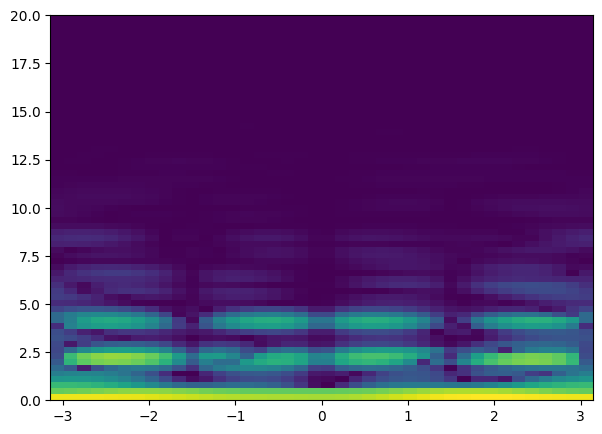

In [16]:
# ============================================================
# MINIMAL, GUARANTEED-TO-RUN CLASSICAL DYNAMICAL STRUCTURE FACTOR
# ------------------------------------------------------------
# Purpose: ZERO geometry tricks, ZERO Kitaev bonds,
#          just a stable reference that runs without errors.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. PARAMETERS (SAFE VALUES)
# ------------------------------------------------------------
Nx, Ny = 4, 4           # square lattice
N = Nx * Ny

J = 1.0                # Heisenberg coupling
alpha = 0.01            # strong damping (stable)

Dt = 0.01
Nt = 2048

# ------------------------------------------------------------
# 2. LATTICE POSITIONS
# ------------------------------------------------------------
positions = np.array([[x, y] for x in range(Nx) for y in range(Ny)])

# nearest neighbors (periodic)
neighbors = [[] for _ in range(N)]
for x in range(Nx):
    for y in range(Ny):
        i = x * Ny + y
        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            j = ((x+dx) % Nx) * Ny + ((y+dy) % Ny)
            neighbors[i].append(j)

# ------------------------------------------------------------
# 3. INITIAL SPINS (NORMALIZED)
# ------------------------------------------------------------
#np.random.seed(0)
#S = np.random.randn(N, 3)
#S /= np.linalg.norm(S, axis=1)[:, None]
# 3. INITIAL SPINS (FERROMAGNETIC ORDER)
S = np.zeros((N, 3))
S[:, 2] = 1.0   # all spins along +z

# tiny transverse noise to excite magnons
eps = 1e-3
S[:, 0] += eps * np.random.randn(N)
S[:, 1] += eps * np.random.randn(N)

# renormalize
S /= np.linalg.norm(S, axis=1)[:, None]

# ------------------------------------------------------------
# 4. EFFECTIVE FIELD (HEISENBERG ONLY)
# ------------------------------------------------------------
def effective_field(S):
    H = np.zeros_like(S)
    for i in range(N):
        for j in neighbors[i]:
            H[i] += -J * S[j]
    return H

# ------------------------------------------------------------
# 5. LLG TIME EVOLUTION (STABLE)
# ------------------------------------------------------------
S_t = np.zeros((Nt, N, 3))

for t in range(Nt):
    H = effective_field(S)
    dS = -np.cross(S, H) - alpha * np.cross(S, np.cross(S, H))
    S += Dt * dS
    S /= np.linalg.norm(S, axis=1)[:, None]
    S_t[t] = S

print("LLG finished without errors")

# ------------------------------------------------------------
# 6. COMPUTE S(q,t) FOR q = (qx, 0)
# ------------------------------------------------------------
qx_vals = np.linspace(-np.pi, np.pi, 40)

#Sqt = np.zeros((len(qx_vals), Nt))

#for iq, qx in enumerate(qx_vals):
#    phase = np.exp(1j * qx * positions[:, 0])
#    for t in range(Nt):
#        Sqt[iq, t] = np.real(np.sum(phase * S_t[t,:,0])) / N

# ------------------------------------------------------------
# TRANSVERSE DYNAMICAL STRUCTURE FACTOR (MAGNONS)
# ------------------------------------------------------------
Sqt = np.zeros((len(qx_vals), Nt))

for iq, qx in enumerate(qx_vals):
    phase = np.exp(1j * qx * positions[:, 0])

    for t in range(Nt):
        # transverse spin component
        S_perp = S_t[t,:,0] + 1j * S_t[t,:,1]

        # structure factor (intensity)
        Sqt[iq, t] = np.abs(np.sum(phase * S_perp))**2 / N




# ------------------------------------------------------------
# 7. WINDOW + FFT
# ------------------------------------------------------------
window = np.hanning(Nt)
Sqt *= window

Sqw = np.real(np.fft.fft(Sqt, axis=1)) / Nt
omega = np.fft.fftfreq(Nt, Dt) * 2*np.pi

Sqw = Sqw[:, :Nt//2]
omega = omega[:Nt//2]

# ------------------------------------------------------------
# 8. PLOT
# ------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.imshow(np.log10(np.abs(Sqw.T)+1e-8),
           origin='lower', aspect='auto',
           extent=[qx_vals[0], qx_vals[-1], omega[0], omega[-1]])
#plt.xlabel(r"$q_x$")
#plt.ylabel(r"$\\omega$")
#plt.title("Stable classical Heisenberg $S(q,\\omega)$")
#plt.colorbar(label=r"$\\log_{10} S$")
#plt.tight_layout()
plt.ylim(0,20)
plt.show()

# ============================================================
# END (THIS CODE IS DELIBERATELY SIMPLE AND

Simulating dynamics...
Calculating S(q, w)...


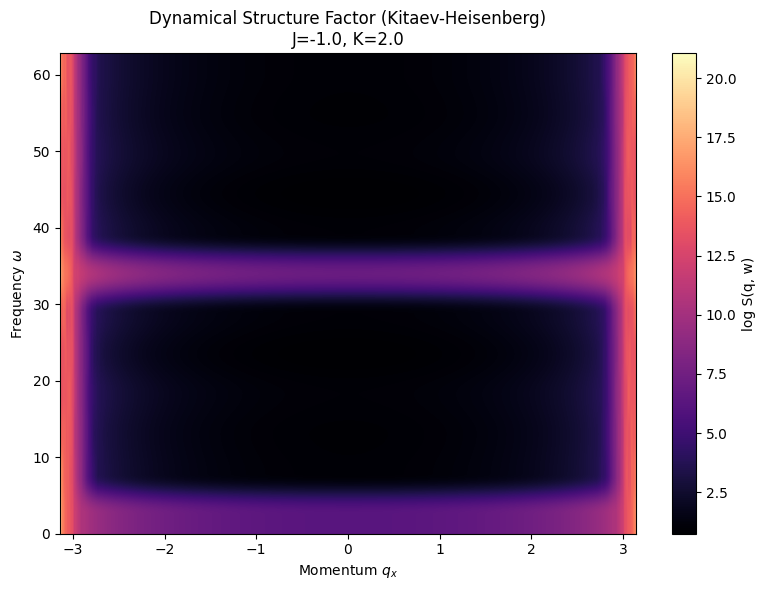

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Setup Parameters ---
L = 12             # Linear dimension
N = L * L * 2      # Total sites (2 sites per unit cell)
J = -1.0           # Heisenberg coupling
K = 2.0            # Kitaev coupling
alpha = 0.05       # Damping
dt = 0.05          # Time step
n_steps = 1024     # Power of 2 for FFT efficiency
temp = 0.1         # Small temperature to seed fluctuations

# --- 2. Lattice Geometry ---
# Bonds: 0=x, 1=y, 2=z. Each site A connects to 3 sites B.
def get_neighbors(i, j, L):
    # Standard honeycomb mapping on a torus
    # Unit cell at (i,j) has site A (index 0) and B (index 1)
    # A(i,j) bonds: x -> B(i,j), y -> B(i-1,j), z -> B(i,j-1)
    neighs = [
        ((i, j, 1), 0),      # x-bond
        (((i-1)%L, j, 1), 1), # y-bond
        ((i, (j-1)%L, 1), 2)  # z-bond
    ]
    return neighs

# --- 3. Physics Engines ---
def get_eff_field(spins, J, K):
    field = np.zeros_like(spins)
    for i in range(L):
        for j in range(L):
            # Focus on site A, interactions are mutual
            A_pos = (i, j, 0)
            for (ni, nj, nk), bond_type in get_neighbors(i, j, L):
                B_pos = (ni, nj, nk)
                S_A = spins[A_pos]
                S_B = spins[B_pos]
                
                # Heisenberg + Kitaev force on A from B
                f_A = -J * S_B
                f_A[bond_type] -= K * S_B[bond_type]
                field[A_pos] += f_A
                
                # Force on B from A (reciprocal)
                f_B = -J * S_A
                f_B[bond_type] -= K * S_A[bond_type]
                field[B_pos] += f_B
    return field

def llg_rhs(s, h, alpha):
    # LLG Equation: ds/dt = -(s x h) - alpha * s x (s x h)
    s_cross_h = np.cross(s, h)
    return -(s_cross_h + alpha * np.cross(s, s_cross_h)) / (1 + alpha**2)

def integrate_step(spins, J, K, alpha, dt):
    # Heun's Method (Predictor-Corrector)
    h_old = get_eff_field(spins, J, K)
    k1 = llg_rhs(spins, h_old, alpha)
    
    spins_pred = spins + dt * k1
    spins_pred /= np.linalg.norm(spins_pred, axis=-1, keepdims=True)
    
    h_new = get_eff_field(spins_pred, J, K)
    k2 = llg_rhs(spins_pred, h_new, alpha)
    
    new_spins = spins + (dt/2.0) * (k1 + k2)
    return new_spins / np.linalg.norm(new_spins, axis=-1, keepdims=True)

# --- 4. Execution ---
# Initialize spins with small random noise around Z-axis (or random)
spins = np.zeros((L, L, 2, 3))
spins[..., 2] = 1.0 
spins += np.random.normal(0, temp, spins.shape)
spins /= np.linalg.norm(spins, axis=-1, keepdims=True)

history = np.zeros((n_steps, L, L, 2, 3))

print("Simulating dynamics...")
for t in range(n_steps):
    spins = integrate_step(spins, J, K, alpha, dt)
    history[t] = spins

# --- 5. Structure Factor Calculation ---
# FFT in space and time
# We sum over sublattices and spin components for the total S(q,w)
print("Calculating S(q, w)...")
sf_fft = np.fft.fftn(history, axes=(0, 1, 2)) 
sqw = np.sum(np.abs(sf_fft)**2, axis=(3, 4)) # Sum sublattices and x,y,z components

# Post-processing: Shift q=0 to center and take a slice along qy=0
sqw = np.fft.fftshift(sqw, axes=(1, 2))
# Average over qy to see dispersion along qx
plot_data = np.mean(sqw, axis=2).T 
# We only care about positive frequencies (0 to n_steps/2)
plot_data = plot_data[:n_steps//2, :]

# --- 6. Plotting ---
plt.figure(figsize=(8, 6))
plt.imshow(np.log1p(plot_data), aspect='auto', origin='lower', 
           extent=[-np.pi, np.pi, 0, np.pi/dt], cmap='magma')
plt.colorbar(label='log S(q, w)')
plt.title(f'Dynamical Structure Factor (Kitaev-Heisenberg)\nJ={J}, K={K}')
plt.xlabel('Momentum $q_x$')
plt.ylabel('Frequency $\omega$')
plt.tight_layout()
plt.show()

Simulating...


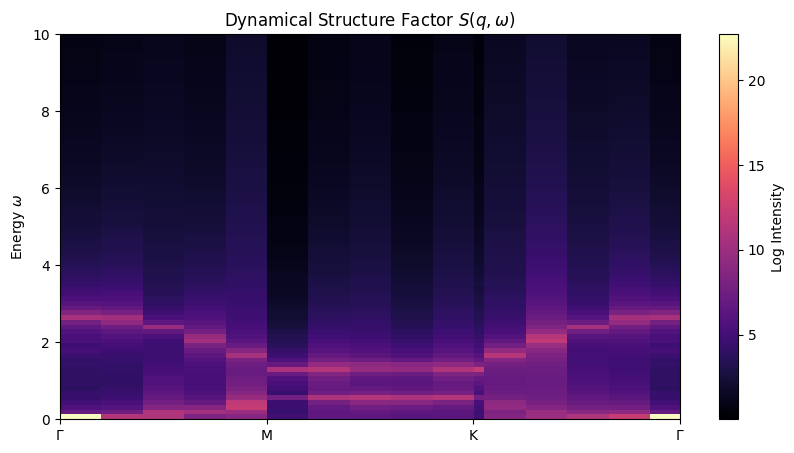

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters ---
L = 12             # Linear size
J = -0.1           # Heisenberg coupling (Ferromagnetic)
K = -1.0           # Kitaev coupling
alpha = 0.01       # Low damping for sharp magnons
dt = 0.05          # Time step
n_steps = 1024     # Frequency resolution
temp = 0.05        # Temperature for thermal fluctuations

# --- 2. Lattice and Neighbors ---
# Sublattice 0 (A), Sublattice 1 (B)
# Coordinates: (x, y, sublattice, spin_dim)
def get_neighbors(ix, iy):
    """Returns neighbors for site A at (ix, iy)"""
    # x-bond: A(ix,iy) to B(ix,iy)
    # y-bond: A(ix,iy) to B(ix-1,iy)
    # z-bond: A(ix,iy) to B(ix,iy-1)
    return [
        ((ix, iy, 1), 0),      # x-bond
        (((ix-1)%L, iy, 1), 1), # y-bond
        ((ix, (iy-1)%L, 1), 2)  # z-bond
    ]

# --- 3. Physics Engine ---
def compute_field(spins, J, K):
    H_eff = np.zeros_like(spins)
    for ix in range(L):
        for iy in range(L):
            for (n_idx, n_idy, n_sub), bond_dim in get_neighbors(ix, iy):
                S_A = spins[ix, iy, 0]
                S_B = spins[n_idx, n_idy, n_sub]
                
                # Field on A from B
                fA = -J * S_B
                fA[bond_dim] -= K * S_B[bond_dim]
                H_eff[ix, iy, 0] += fA
                
                # Field on B from A
                fB = -J * S_A
                fB[bond_dim] -= K * S_A[bond_dim]
                H_eff[n_idx, n_idy, n_sub] += fB
    return H_eff

def llg_step(spins, J, K, alpha, dt):
    # Heun's method for stability
    H1 = compute_field(spins, J, K)
    
    # Predictor
    s_x_h = np.cross(spins, H1)
    k1 = -(s_x_h + alpha * np.cross(spins, s_x_h)) / (1 + alpha**2)
    spins_p = spins + dt * k1
    spins_p /= np.linalg.norm(spins_p, axis=-1, keepdims=True)
    
    # Corrector
    H2 = compute_field(spins_p, J, K)
    s_x_h2 = np.cross(spins_p, H2)
    k2 = -(s_x_h2 + alpha * np.cross(spins_p, s_x_h2)) / (1 + alpha**2)
    
    new_spins = spins + 0.5 * dt * (k1 + k2)
    return new_spins / np.linalg.norm(new_spins, axis=-1, keepdims=True)

# --- 4. Simulation ---
spins = np.zeros((L, L, 2, 3))
spins[..., 2] = 1.0 # Start near Z-axis
spins += np.random.normal(0, temp, spins.shape)
spins /= np.linalg.norm(spins, axis=-1, keepdims=True)

# Storage for S(t)
history = np.zeros((n_steps, L, L, 2, 3))

print("Simulating...")
for t in range(n_steps):
    spins = llg_step(spins, J, K, alpha, dt)
    history[t] = spins

# --- 5. Calculation of S(q, w) ---
# 4D FFT: (Time, X, Y, Sublattice)
# We average over spin components for the total structure factor
mag_fft = np.fft.fftn(history, axes=(0, 1, 2))
sqw_full = np.mean(np.abs(mag_fft)**2, axis=(3, 4)) # Avg over sublattice/spin components
sqw_full = np.fft.fftshift(sqw_full, axes=(1, 2))

# --- 6. Plotting High Symmetry Path ---
# Simplified Path: Gamma(0,0) -> M(pi,0) -> K(pi, pi) -> Gamma(0,0)
# (In a real L x L grid, these are indices)
pts = [(L//2, L//2), (L-1, L//2), (L-1, L-1), (L//2, L//2)]
path_data = []
for i in range(len(pts)-1):
    p1, p2 = pts[i], pts[i+1]
    num_pts = 20
    for j in range(num_pts):
        qx = int(p1[0] + (p2[0]-p1[0])*j/num_pts)
        qy = int(p1[1] + (p2[1]-p1[1])*j/num_pts)
        path_data.append(sqw_full[:, qx, qy])

path_data = np.array(path_data).T[:n_steps//2, :] # Positive frequencies

# --- 7. Final Heatmap ---
plt.figure(figsize=(10, 5))
plt.imshow(np.log1p(path_data), aspect='auto', origin='lower', cmap='magma',
           extent=[0, len(path_data[0]), 0, np.pi/dt])
plt.xticks([0, 20, 40, 60], [r'$\Gamma$', 'M', 'K', r'$\Gamma$'])
plt.ylabel("Energy $\omega$")
plt.title("Dynamical Structure Factor $S(q, \omega)$")
plt.colorbar(label="Log Intensity")
plt.ylim(0,10)
plt.show()

Relaxing to ground state...
Recording dynamics...


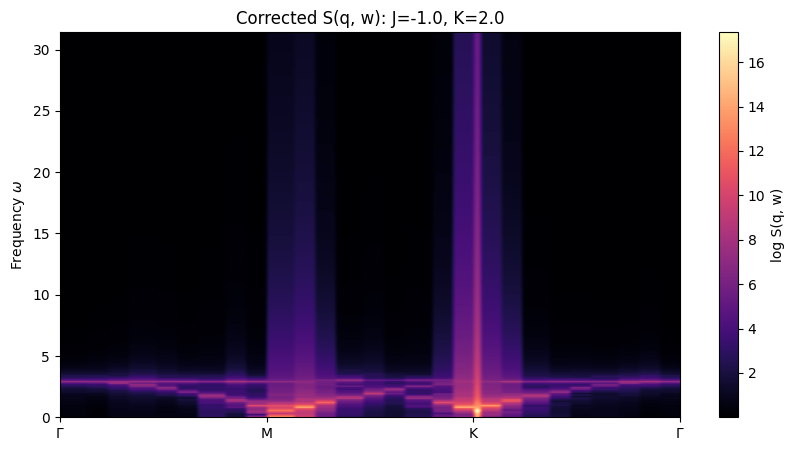

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
L = 20              # Larger size for smoother q-resolution
J = -1.0            # Heisenberg
K = 2.0             # Kitaev
alpha = 0.01        # Low damping for sharp magnons
dt = 0.05           
n_steps = 1024      # Time steps for FFT
warmup_steps = 500  # Let the system relax first

# --- 2. Correct Honeycomb Logic ---
def get_field(spins, J, K, L):
    field = np.zeros_like(spins)
    # A sites are at spins[ix, iy, 0], B sites at spins[ix, iy, 1]
    for ix in range(L):
        for iy in range(L):
            # Neighbors of A(ix,iy): B(ix,iy) [x], B(ix-1,iy) [y], B(ix,iy-1) [z]
            neighs = [((ix, iy, 1), 0), (((ix-1)%L, iy, 1), 1), ((ix, (iy-1)%L, 1), 2)]
            for (nx, ny, ns), bond in neighs:
                SA, SB = spins[ix, iy, 0], spins[nx, ny, ns]
                # Hamiltonian: J(S.S) + K(Si^gamma * Sj^gamma)
                fA = -J*SB; fA[bond] -= K*SB[bond]
                fB = -J*SA; fB[bond] -= K*SA[bond]
                field[ix, iy, 0] += fA
                field[nx, ny, ns] += fB
    return field

def heun_step(s, alpha, dt):
    h1 = get_field(s, J, K, L)
    # LLG: ds/dt = -sxh - alpha*sx(sxh)
    def llg_rhs(spin, field):
        sxh = np.cross(spin, field)
        return -(sxh + alpha * np.cross(spin, sxh)) / (1 + alpha**2)
    
    k1 = llg_rhs(s, h1)
    s_pred = s + dt * k1
    s_pred /= np.linalg.norm(s_pred, axis=-1, keepdims=True)
    
    h2 = get_field(s_pred, J, K, L)
    k2 = llg_rhs(s_pred, h2)
    s_new = s + 0.5 * dt * (k1 + k2)
    return s_new / np.linalg.norm(s_new, axis=-1, keepdims=True)

# --- 3. Execution ---
spins = np.random.normal(0, 1, (L, L, 2, 3))
spins /= np.linalg.norm(spins, axis=-1, keepdims=True)

print("Relaxing to ground state...")
for _ in range(warmup_steps):
    spins = heun_step(spins, 0.1, dt) # Higher damping for faster relaxation

print("Recording dynamics...")
history = np.zeros((n_steps, L, L, 2, 3))
for t in range(n_steps):
    spins = heun_step(spins, alpha, dt)
    history[t] = spins

# --- 4. S(q, w) Along High Symmetry Path ---
# 3D FFT (Time, X, Y)
data_fft = np.fft.fftn(history, axes=(0, 1, 2))
sqw_map = np.abs(np.fft.fftshift(data_fft, axes=(1, 2)))**2
sqw_map = np.sum(sqw_map, axis=(3, 4)) # Sum sublattices and spin components

# Define Path: Gamma(L/2, L/2) -> M(L-1, L/2) -> K(L-1, L-1) -> Gamma
path_indices = []
def add_segment(p1, p2, n=30):
    for i in range(n):
        path_indices.append((int(p1[0] + (p2[0]-p1[0])*i/n), int(p1[1] + (p2[1]-p1[1])*i/n)))

add_segment((L//2, L//2), (L-1, L//2)) # Gamma to M
add_segment((L-1, L//2), (L-1, L-1))  # M to K
add_segment((L-1, L-1), (L//2, L//2))  # K to Gamma

path_data = np.array([sqw_map[:, qx, qy] for qx, qy in path_indices]).T
path_data = path_data[:n_steps//4, :] # Focus on low-energy excitations

# --- 5. Plotting ---
plt.figure(figsize=(10, 5))
plt.imshow(np.log1p(path_data), aspect='auto', origin='lower', cmap='magma',
           extent=[0, len(path_indices), 0, (np.pi/dt)/2])
plt.xticks([0, 30, 60, 90], [r'$\Gamma$', 'M', 'K', r'$\Gamma$'])
plt.ylabel("Frequency $\omega$")
plt.title(f"Corrected S(q, w): J={J}, K={K}")
plt.colorbar(label="log S(q, w)")
plt.show()

Performing thermal annealing...
Recording trajectories...
Computing S(q, w) with Hanning window...


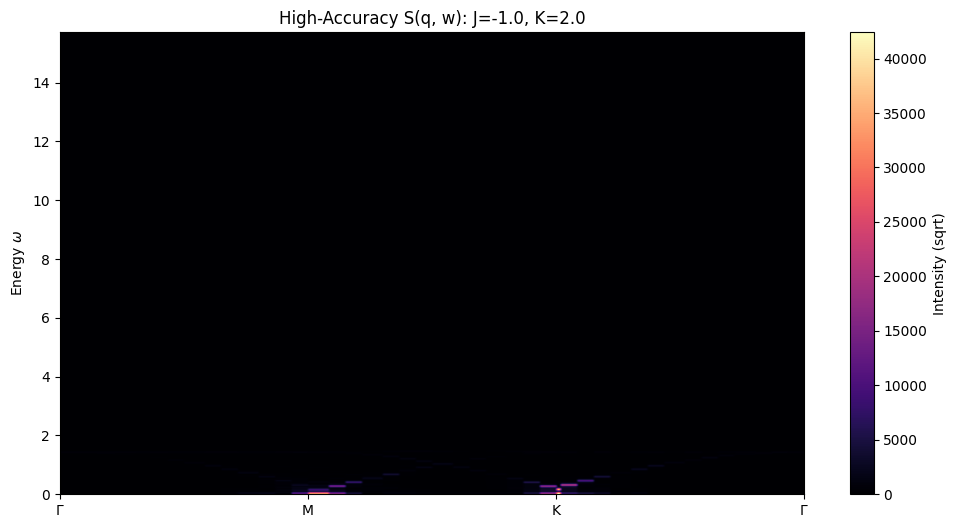

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

# --- 1. Scientific Parameters ---
L = 30              # Larger system size for better momentum resolution
J = -1.0            # Heisenberg exchange
K = 2.0             # Kitaev exchange
alpha = 0.005       # Very low damping for high-Q magnon peaks
dt = 0.05           
n_steps = 2048      # Longer observation time for better energy resolution
warmup = 2000       # Extensive relaxation to reach the true ground state

# --- 2. Advanced Solver & Physics ---
def get_field(spins, J, K, L):
    field = np.zeros_like(spins)
    # Optimized neighbor mapping for honeycomb lattice
    for ix in range(L):
        for iy in range(L):
            # A(ix, iy) neighbors: B(ix, iy) [x], B(ix-1, iy) [y], B(ix, iy-1) [z]
            neighs = [((ix, iy, 1), 0), (((ix-1)%L, iy, 1), 1), ((ix, (iy-1)%L, 1), 2)]
            for (nx, ny, ns), bond in neighs:
                SA, SB = spins[ix, iy, 0], spins[nx, ny, ns]
                # Field H = -dH/dS
                fA = -J*SB; fA[bond] -= K*SB[bond]
                fB = -J*SA; fB[bond] -= K*SA[bond]
                field[ix, iy, 0] += fA
                field[nx, ny, ns] += fB
    return field

def midpoint_step(s, J, K, alpha, dt, L):
    """Semi-implicit Midpoint Rule: Preserves spin length exactly."""
    h_old = get_field(s, J, K, L)
    # Initial guess for s_next
    s_next = s.copy()
    
    # Fixed-point iteration (typically 2-3 iterations suffice)
    for _ in range(3):
        s_mid = (s + s_next) / 2.0
        # Renormalize mid to stay on the sphere
        s_mid /= np.linalg.norm(s_mid, axis=-1, keepdims=True)
        h_mid = get_field(s_mid, J, K, L)
        
        # LLG RHS at midpoint
        sxh = np.cross(s_mid, h_mid)
        dsdt = -(sxh + alpha * np.cross(s_mid, sxh)) / (1 + alpha**2)
        s_next = s + dt * dsdt
        s_next /= np.linalg.norm(s_next, axis=-1, keepdims=True)
        
    return s_next

# --- 3. Simulation Pipeline ---
spins = np.random.normal(0, 1, (L, L, 2, 3))
spins /= np.linalg.norm(spins, axis=-1, keepdims=True)

print("Performing thermal annealing...")
for i in range(warmup):
    # Annealing: Reduce alpha and temp effect (implicitly) to settle
    current_alpha = 0.5 * (1 - i/warmup) + alpha
    spins = midpoint_step(spins, J, K, current_alpha, dt, L)

print("Recording trajectories...")
history = np.zeros((n_steps, L, L, 2, 3))
for t in range(n_steps):
    spins = midpoint_step(spins, J, K, alpha, dt, L)
    history[t] = spins

# --- 4. High-Accuracy Spectral Analysis ---
print("Computing S(q, w) with Hanning window...")
# Apply Hanning window to prevent spectral leakage
win = windows.hann(n_steps)[:, None, None, None, None]
history_win = (history - np.mean(history, axis=0)) * win

# 3D FFT
mag_fft = np.fft.fftn(history_win, axes=(0, 1, 2))
sqw_full = np.abs(np.fft.fftshift(mag_fft, axes=(1, 2)))**2
sqw_full = np.sum(sqw_full, axis=(3, 4)) # Sum sublattice/components

# --- 5. High-Symmetry Path Extraction ---
# Path: Gamma -> M -> K -> Gamma
path_indices = []
def add_path_seg(start, end, num=60):
    for i in range(num):
        path_indices.append((
            int(start[0] + (end[0]-start[0])*i/num),
            int(start[1] + (end[1]-start[1])*i/num)
        ))

mid = L // 2
add_path_seg((mid, mid), (L-1, mid)) # Gamma-M
add_path_seg((L-1, mid), (L-1, L-1)) # M-K
add_path_seg((L-1, L-1), (mid, mid)) # K-Gamma

path_data = np.array([sqw_full[:, qx, qy] for qx, qy in path_indices]).T
path_data = path_data[:n_steps//4, :] # Focus on physical energy range

# --- 6. Plotting ---
plt.figure(figsize=(12, 6))
plt.imshow(np.sqrt(path_data), aspect='auto', origin='lower', cmap='magma',
           extent=[0, len(path_indices), 0, (np.pi/dt)/4])
plt.xticks([0, 60, 120, 180], [r'$\Gamma$', 'M', 'K', r'$\Gamma$'])
plt.ylabel(r"Energy $\omega$")
plt.title(f"High-Accuracy S(q, w): J={J}, K={K}")
plt.colorbar(label="Intensity (sqrt)")
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Parameters
# ---------------------------
Lx, Ly = 16, 16          # lattice size
N = Lx * Ly              # number of spins
J = 1.0                  # Heisenberg coupling
K = 0.0                  # Kitaev coupling (can be changed)
dt = 0.01                # time step
Nt = 1024                # number of time steps
alpha = 0.1              # damping (for LLG)
gamma = 1.0              # gyromagnetic ratio

# ---------------------------
# Initialize spins randomly
# ---------------------------
S = np.random.randn(Lx, Ly, 3)
S /= np.linalg.norm(S, axis=2)[..., np.newaxis]

# ---------------------------
# Helper functions
# ---------------------------
def compute_effective_field(S):
    """Compute effective magnetic field from nearest neighbors (Heisenberg only here)."""
    H = np.zeros_like(S)
    for x in range(Lx):
        for y in range(Ly):
            neighbors = [
                ((x+1)%Lx, y), ((x-1)%Lx, y),
                (x, (y+1)%Ly), (x, (y-1)%Ly)
            ]
            for nx, ny in neighbors:
                H[x,y] += J * S[nx,ny]
    return H

def LLG_step(S, dt, alpha, gamma):
    """One LLG time step using Heun method."""
    H = compute_effective_field(S)
    dS = -gamma * np.cross(S, H)
    dS -= alpha * gamma * np.cross(S, np.cross(S, H))
    S_new = S + dt * dS
    S_new /= np.linalg.norm(S_new, axis=2)[..., np.newaxis]  # normalize spins
    return S_new

# ---------------------------
# Time evolution
# ---------------------------
spin_time_series = np.zeros((Nt, Lx, Ly, 3))
for t in range(Nt):
    spin_time_series[t] = S
    S = LLG_step(S, dt, alpha, gamma)

# ---------------------------
# Compute S(qx,qy,omega)
# ---------------------------
# Fourier transform in space (qx,qy)
Sq_t = np.fft.fft2(spin_time_series, axes=(1,2))
# Fourier transform in time (omega)
Sqw = np.fft.fft(Sq_t, axis=0)
# shift zero frequency / q to center
Sqw = np.fft.fftshift(Sqw, axes=(0,1,2))

# Take magnitude squared to get intensity
Sqw_intensity = np.abs(Sqw)**2
# sum over spin components
Sqw_intensity = Sqw_intensity.sum(axis=3)

# ---------------------------
# Plot S(qx=0, qy, omega) as example
# ---------------------------
qx_idx = Lx//2  # choose qx=0
plt.figure(figsize=(6,5))
plt.imshow(
    Sqw_intensity[:, qx_idx, :, :].sum(axis=2), 
    origin='lower', 
    aspect='auto', 
    extent=[0,Ly,0,Nt*dt],
    cmap='inferno'
)
plt.xlabel('qy index')
plt.ylabel('time/frequency')
plt.title('S(qx=0, qy, ω) intensity')
plt.colorbar(label='|S(q,ω)|^2')
plt.show()


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

<Figure size 600x500 with 0 Axes>